# ÖDEV-3

**Yazar : Uğur Selim Özen**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go


#for quick viz
import seaborn as sns

#ml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import random

**⚫ Aşağıdaki kod bloğunda veri temizliği ve özellik mühendisliği kısımları uygulandı ayrıca Label Encoding işlemleri yapabilmek için bazı çok fazla eşsiz değer içeren kolonlar için gruplama işlmeleri yapıldı.**

In [2]:
df = pd.read_csv('auto_insurance.csv')
df = df.drop(['_c39','Unnamed: 0'], axis = 1)
df['umbrella_limit'] = df.umbrella_limit.fillna("9999")
df['police_report_available'] = df.police_report_available.fillna("MISSING")
df['policy_csl'] = df.policy_csl.fillna("MISSING")
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['claim_day_of_policy'] = (df.incident_date -  df.policy_bind_date).dt.days
df['location_check'] = np.nan
df['location_check'] = np.where(df['policy_state'] == df['incident_state'], True, False)
df['fraud_reported'] = df['fraud_reported'].str.replace('Y', '1')
df['fraud_reported'] = df['fraud_reported'].str.replace('N', '0')
df['fraud_reported'] = df['fraud_reported'].astype(int)
df['umbrella_limit'] = df.umbrella_limit.astype(str)
umbrealla = df['umbrella_limit'].unique()
for umb in umbrealla:
  if (umb != '0.0') & (umb != '9999'):
    df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other')
    
hobbies = df['insured_hobbies'].unique()
for hobby in hobbies:
  if (hobby != 'chess') & (hobby != 'cross-fit'):
    df['insured_hobbies'] = df['insured_hobbies'].str.replace(hobby, 'other')

df['age'] = df.age.fillna(9999)
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65','9999']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 9999]
df['age_group'] = pd.cut(df['age'], bins = bins, labels = bin_labels, include_lowest = True)

bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']
df['months_as_customer_groups'] = pd.cut(df['months_as_customer'], bins = 10, labels = bin_labels, include_lowest= True)

bins = list(np.linspace(0,2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']
df['policy_annual_premium_groups'] = pd.cut(df['policy_annual_premium'], bins = bins, labels=bin_labels)

bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']
df['policy_deductable_group'] = pd.cut(df['policy_deductable'], bins = bins, labels = bin_labels)

bins = list(np.linspace(10000,100000, 10, dtype = int))
bin_labels = ['10000-20000', '20000-30000', '30000-40000' , '40000-50000', '50000-60000', '60000-70000' , '70000-80000', '80000-90000' , '90000-100000']
df['capital_gains_groups'] = pd.cut(df["capital-gains"], bins = bins, labels = bin_labels)

bins = list(np.linspace(-110000 , 0 , 12, dtype = int))
bin_labels = ['-110000 - -100000' , '-100000 - -90000',  '-90000 - -80000' ,   '-80000 - -70000','-70000 - -60000', '-60000 - -50000' , '-50000 - -40000', '-40000 - -30000' ,'-30000 - -20000' ,'-20000 - -10000','-10000 - 0']
df['capital_loss_groups'] = pd.cut(df["capital-loss"], bins = bins, labels = bin_labels)

bins = list(np.linspace(0,120000, 7, dtype = int))
bin_labels = ['0-20000' ,'20000-40000','40000-60000' ,'60000-80000','80000-100000','100000-120000']
df['total_claim_amount_groups'] = pd.cut(df["total_claim_amount"], bins = bins, labels = bin_labels)


bins = list(np.linspace(0,10000, 11, dtype = int))
bin_labels = ['0-1000', '1000-2000', '2000-3000', '3000-4000' , '4000-5000', '5000-6000', '6000-7000' , '7000-8000', '8000-9000' , '9000-10000']
df['claim_day_of_policy_groups'] = pd.cut(df["claim_day_of_policy"], bins = bins, labels = bin_labels)


df = df.drop(['age', 'months_as_customer', 'policy_deductable', 'policy_annual_premium' ,"capital-gains" ,"capital-loss","total_claim_amount","claim_day_of_policy"], axis = 1)

required_columns = ['incident_date','policy_state', 'policy_csl', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
        'capital_loss_groups', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount_groups','auto_make',
       'auto_model', 'auto_year', 'claim_day_of_policy_groups',
       'location_check', 'age_group', 'months_as_customer_groups',
       'policy_annual_premium_groups', 'policy_deductable_group' , 'fraud_reported']

df = df[required_columns]

C:\Users\Ugur\AppData\Local\Temp/ipykernel_1552/2790101825.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other')


In [3]:
valData = df.sort_values(by='incident_date',ascending=False).head(200)
train_testData = df.sort_values(by='incident_date',ascending=False).tail(800)

In [4]:
valData = valData.drop(["incident_date","insured_zip","incident_location"],axis=1)
train_testData = train_testData.drop(["incident_date","insured_zip","incident_location"],axis=1)

 **⚫ Alttaki iki kod bloğunda train_test ve validasyon verilerine ait kolonların eşssiz değerleri görülmektedir.Açıkça görüldüğü üzere train_test ve validasyon verisetleri arasında düzgün bir dağılım söz konusu olmayıp train_test verisetindeki bazı label değerleri validasyon setinde mevcut değildir.**

In [5]:
for col in train_testData.columns:
        print(str(col) +" : " + str(train_testData[col].nunique()))

policy_state : 3
policy_csl : 4
umbrella_limit : 3
insured_sex : 2
insured_education_level : 7
insured_occupation : 14
insured_hobbies : 3
insured_relationship : 6
capital_loss_groups : 10
incident_type : 4
collision_type : 4
incident_severity : 4
authorities_contacted : 5
incident_state : 7
incident_city : 7
incident_hour_of_the_day : 24
number_of_vehicles_involved : 4
property_damage : 3
bodily_injuries : 3
witnesses : 4
police_report_available : 4
total_claim_amount_groups : 6
auto_make : 14
auto_model : 39
auto_year : 21
claim_day_of_policy_groups : 10
location_check : 2
age_group : 11
months_as_customer_groups : 10
policy_annual_premium_groups : 5
policy_deductable_group : 3
fraud_reported : 2


In [6]:
for col in valData.columns:
        print(str(col) +" : " + str(valData[col].nunique()))

policy_state : 3
policy_csl : 4
umbrella_limit : 3
insured_sex : 2
insured_education_level : 7
insured_occupation : 14
insured_hobbies : 3
insured_relationship : 6
capital_loss_groups : 9
incident_type : 4
collision_type : 4
incident_severity : 4
authorities_contacted : 5
incident_state : 7
incident_city : 7
incident_hour_of_the_day : 24
number_of_vehicles_involved : 4
property_damage : 3
bodily_injuries : 3
witnesses : 4
police_report_available : 4
total_claim_amount_groups : 5
auto_make : 14
auto_model : 38
auto_year : 21
claim_day_of_policy_groups : 10
location_check : 1
age_group : 10
months_as_customer_groups : 10
policy_annual_premium_groups : 3
policy_deductable_group : 3
fraud_reported : 2


# TRAIN TEST DATA ONE-HOT-ENCODING

In [7]:
cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups','location_check','policy_deductable_group','capital_loss_groups','total_claim_amount_groups','claim_day_of_policy_groups']
for col in cat_cols:
   train_testData[col] = train_testData[col].astype('object')

columns_to_encode = []
for col in train_testData.columns:
  if train_testData[col].dtype == 'object':
    columns_to_encode.append(col)

oneHotEncoded_train_testData = pd.get_dummies(train_testData, columns = columns_to_encode)

In [8]:
features = []
for col in oneHotEncoded_train_testData.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X = oneHotEncoded_train_testData[features]
y = oneHotEncoded_train_testData[target]

In [9]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

D:\Program Files\Python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

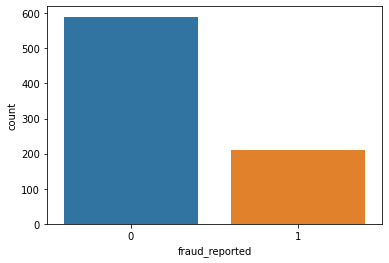

In [10]:
chck = pd.DataFrame()
chck['fraud_reported'] = y

sns.countplot(chck['fraud_reported'])

### 3. IMBALANCE DATASETTE TRAIN_TEST SPLIT UYGULARKEN HANGİ DURUMLAR GÖZ ÖNÜNE ALINMALIDIR ?
**Yukarıdaki grafikte hedef değişken konumunda olan suistimal durumunun train_test verisetinde dağılımına baktığımızda 0 lar çok fazla bulunmaktadır.Bu durum veriseti eğitilirken modelin çok fazla 0 demesine eğilim gösterebilir.Çözüm olarak OVERSAMPLING yöntemi uygulanarak ilgili verisetinde 1 değerleri artırılarak 1 ve 0 lar yaklaşık olarak eşit sayıya yaklaştırılabilir ancak burada eğitilecek verisetine olmayan verileri eklememiz sorun oluşturabilir.Diğer bir çözüm ise UNDERSAMPLING  , burada ise 1 ve 0 sayılarını eşitlemek için 0 lar verisetinden çıkartılır ancak bu durum eğitilecek verisetinde ciddi şekilde veri kaybına sebep olmaktadır.Aşağıdaki use case bazında OVERSAMPLING yöntemi uygulanmıştır.** 

In [11]:
oversample = SMOTE(random_state=9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,  random_state = 42)
X_over, y_over = oversample.fit_resample(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, random_state = 1)

D:\Program Files\Python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

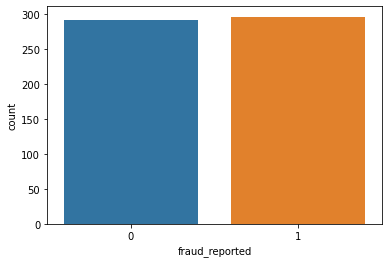

In [12]:
chck = pd.DataFrame()
chck['fraud_reported'] = y_train

sns.countplot(chck['fraud_reported'])

92.46031746031747

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       128
           1       0.93      0.92      0.92       124

    accuracy                           0.92       252
   macro avg       0.92      0.92      0.92       252
weighted avg       0.92      0.92      0.92       252



<AxesSubplot:>

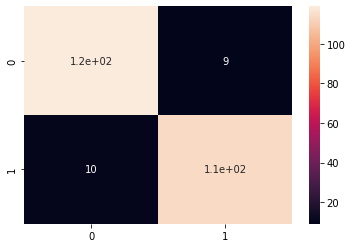

In [13]:
rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)

preds = rfc.predict(X_test)

score = rfc.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

# VALIDATION DATA ONE-HOT-ENCODING

In [14]:
cat_cols1 = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups','location_check','policy_deductable_group','capital_loss_groups','total_claim_amount_groups','claim_day_of_policy_groups']
for col in cat_cols1:
  valData[col] = valData[col].astype('object')

columns_to_encode1 = []
for col in valData.columns:
  if valData[col].dtype == 'object':
    columns_to_encode1.append(col)

oneHotEncoded_valData = pd.get_dummies(valData, columns = columns_to_encode1)

In [15]:
features1 = []
for col in oneHotEncoded_valData.columns:
  if col != 'fraud_reported':
    features1.append(col)

target1 = 'fraud_reported'

X_val = oneHotEncoded_valData[features1]
y_val = oneHotEncoded_valData[target1]

In [16]:
from sklearn.preprocessing import StandardScaler

X_val = sc.transform(X_val)

D:\Program Files\Python\lib\site-packages\sklearn\base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- age_group_15-20
- auto_model_Ultima
- capital_loss_groups_-100000 - -90000
- location_check_True
- policy_annual_premium_groups_very high
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 188 features, but StandardScaler is expecting 195 features as input.

### 1. ONE-HOT ENCODING MODELİN GÖRMEDİĞİ (VALİDASYON SETİNE) NASIL UYGULANIR ?
**⚫ Model eğtildikten sonra validasyon veriseti üzerinde One-Hot-Encoding işlemi yapıldıktan sonra tahminleme yapılırken aşağıdaki hata alınmıştır bu hatanın sebebi en başta belirtildiği gibi veriseti train_test ve validasyon'a uniform olarak bölünmediği için train_test verisinde olan bazı kolonlar validasyon verisinde mevcut değildir.** 

In [17]:
preds = rfc.predict(X_val)
score = rfc.score(X_val, y_val)
print(score*100)

print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)

sns.heatmap(cm, annot=True)

D:\Program Files\Python\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 188 features, but RandomForestClassifier is expecting 195 features as input.

#### SOLUTION 1 WHEN ONE-HOT-ENCODING FOR VALIDATION DATASET

⚫ **Yukarıdaki hataya ilk çözüm yolu olarak burada pandas kütüphanesinden reindex metodu kullanılarak iki veriseti arasındaki eksik kolonlar birbiri ile tamamlanmıştır.Bu çözümde One-Hot Encoding yöntemi uygulanabilmiştir ancak modelin performansı iyi bir sonuç vermemiştir.**

In [18]:
col_list = oneHotEncoded_train_testData.columns.tolist()

In [19]:
cat_cols1 = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups','location_check','policy_deductable_group','capital_loss_groups','total_claim_amount_groups','claim_day_of_policy_groups']
for col in cat_cols1:
  valData[col] = valData[col].astype('object')

columns_to_encode1 = []
for col in valData.columns:
  if valData[col].dtype == 'object':
    columns_to_encode1.append(col)

oneHotEncoded_valData = pd.get_dummies(valData, columns = columns_to_encode1)

In [20]:
oneHotEncoded_valData = oneHotEncoded_valData.reindex(columns=col_list).fillna(0)

In [21]:
for col in oneHotEncoded_valData.columns :
    if oneHotEncoded_valData[col].dtype == "float64" :
        oneHotEncoded_valData[col] = oneHotEncoded_valData[col].astype("uint8")

In [22]:
oneHotEncoded_train_testData.dtypes.value_counts()

uint8    190
int64      5
int32      1
dtype: int64

In [23]:
oneHotEncoded_valData.dtypes.value_counts()

uint8    190
int64      5
int32      1
dtype: int64

In [24]:
oneHotEncoded_train_testData.shape

(800, 196)

In [25]:
oneHotEncoded_valData.shape

(200, 196)

In [26]:
oneHotEncoded_valData.head()

,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,auto_year,fraud_reported,policy_state_IL,policy_state_IN,policy_state_OH,policy_csl_100/300,...,months_as_customer_groups_451-500,months_as_customer_groups_51-100,policy_annual_premium_groups_high,policy_annual_premium_groups_low,policy_annual_premium_groups_medium,policy_annual_premium_groups_very high,policy_annual_premium_groups_very low,policy_deductable_group_0-500,policy_deductable_group_1501-2000,policy_deductable_group_501-1000
752,2,4,0,2,1997,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
74,18,3,1,0,2005,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
914,2,4,0,2,1998,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
883,18,3,0,3,2005,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
839,4,1,2,2,2011,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0


In [27]:
features1 = []
for col in oneHotEncoded_valData.columns:
  if col != 'fraud_reported':
    features1.append(col)

target1 = 'fraud_reported'

X_val = oneHotEncoded_valData[features1]
y_val = oneHotEncoded_valData[target1]

In [28]:
from sklearn.preprocessing import StandardScaler

X_val = sc.transform(X_val)

78.5
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       163
           1       0.42      0.43      0.43        37

    accuracy                           0.79       200
   macro avg       0.65      0.65      0.65       200
weighted avg       0.79      0.79      0.79       200



<AxesSubplot:>

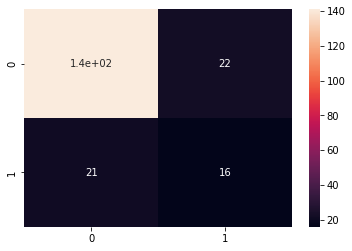

In [29]:
preds = rfc.predict(X_val)
score = rfc.score(X_val, y_val)
print(score*100)

print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)

sns.heatmap(cm, annot=True)

#### SOLUTION 2 WHEN ONE-HOT-ENCODING FOR VALIDATION DATASET
⚫ **Yukarıdaki hataya ikinci ve etkili çözüm yolu olarak burada scikit-learn kütüphanesinden OneHotEncoder metodu kullanılarak train_test üzerinde fit_transform ardından validasyon üzerinde transform uygulanmıştır.Bu çözümde OneHotEncoder metodunda ,  train_test setinde bulunup validasyon seti içerisinde bulunmayan labellar için handle_unkown parametresi kullanılarak modelin görmediği verisetine One-Hot Encoding uygulanmıştır ve modelin performansı çok iyi bir sonuç vermiştir.**

In [30]:
y = train_testData['fraud_reported']
train_testData1 = train_testData.iloc[: , :31]

y_val = valData['fraud_reported']
valData1 = valData.iloc[: , :31]

In [31]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')
oneHotEncoded_train_testData1 = encoder.fit_transform(train_testData1).toarray()   # Assume for simplicity all features are categorical.
# Apply the encoder.
oneHotEncoded_valData1 = encoder.transform(valData1).toarray() 

In [32]:
X = oneHotEncoded_train_testData1

In [33]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

In [34]:
oversample = SMOTE(random_state=9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,  random_state = 42)
X_over, y_over = oversample.fit_resample(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, random_state = 1)

D:\Program Files\Python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

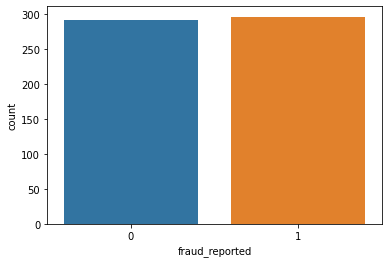

In [35]:
chck = pd.DataFrame()
chck['fraud_reported'] = y_train

sns.countplot(chck['fraud_reported'])

92.46031746031747
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       128
           1       0.91      0.94      0.92       124

    accuracy                           0.92       252
   macro avg       0.92      0.92      0.92       252
weighted avg       0.92      0.92      0.92       252



<AxesSubplot:>

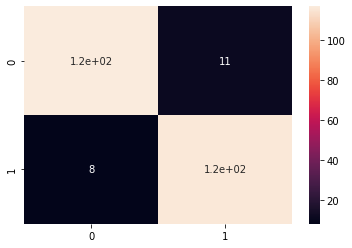

In [36]:
rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)

preds = rfc.predict(X_test)

score = rfc.score(X_test, y_test)
print(score*100)
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True)

In [37]:
oneHotEncoded_valData1.shape

(200, 248)

In [38]:
X1 = oneHotEncoded_valData1
y1 = y_val

In [39]:
oneHotEncoded_valData1.shape

(200, 248)

In [40]:
from sklearn.preprocessing import StandardScaler

X1 = sc.transform(X1)

79.0
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       163
           1       0.44      0.46      0.45        37

    accuracy                           0.79       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.79      0.79      0.79       200



<AxesSubplot:>

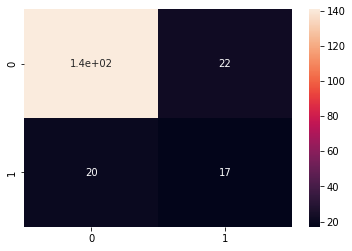

In [41]:
preds = rfc.predict(X1)
score = rfc.score(X1, y1)
print(score*100)
print(classification_report(y1, preds))

cm = confusion_matrix(y1, preds)

sns.heatmap(cm, annot=True)

### ADJUSTING THRESHOLD WITH PREDICT_PROBA

### 5. Predict_Proba metodu ile oran nasıl hesaplanır ve threshold nasıl değiştirilir ?
**⚫ Model eğitildikten sonra test veriseti üzerinde predict metodu yerine predict_proba metodu ile de tahminleme yapabiliriz.Burada default olarak threshold değeri 0.5 dir yani 1 ve 0 ların olasılığı %50 ve eşit olarak hesaplanır , örneğin tahminlememizde çıkan true negative lerin (normalde suistimal olduğu halde bu suistimal değil diye yanlış karar verdiğimiz bölüm) sayısını azaltmak için threshold u default değer olan %50 den %40 a indirerek true negative lerin sayısı azaltılıp false positive lerin sayısı artmış olur , burada model %40 a kadar 0 ları tahminlerken %40 tan yukarısını 1 olarak kabul etmektedir.Tam tersi durumda ise thresholdu örneğin %60'a çıkartarak false negative lerin sayısı azaltılıp %60'a kadar 0 tahminlenip %60 dan sonrası 1 olarak tahminlenir.Bu işlemlerin kod olarak nasıl yapılacağı aşağıdaki kod bloğunda gösterilmiştir.**

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       128
           1       1.00      0.69      0.82       124

    accuracy                           0.85       252
   macro avg       0.89      0.85      0.84       252
weighted avg       0.88      0.85      0.85       252



<AxesSubplot:>

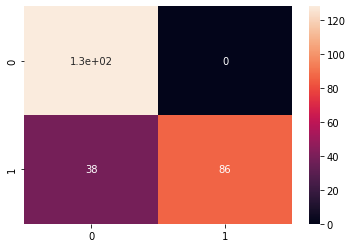

In [42]:
threshold = 0.71
rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)

predicted_proba = (rfc.predict_proba(X_test)[:,1] >= threshold).astype("int")

print(classification_report(y_test, predicted_proba))

cm = confusion_matrix(y_test, predicted_proba)
sns.heatmap(cm, annot=True)

# TRAIN TEST DATA LABEL ENCODING

In [43]:
labelEncoded_train_testData = train_testData1.apply(LabelEncoder().fit_transform)

In [44]:
features = []
for col in labelEncoded_train_testData.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X = labelEncoded_train_testData

In [45]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

In [46]:
oversample = SMOTE(random_state=9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,  random_state = 42)
X_over, y_over = oversample.fit_resample(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, random_state = 1)

92.85714285714286
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       128
           1       0.93      0.93      0.93       124

    accuracy                           0.93       252
   macro avg       0.93      0.93      0.93       252
weighted avg       0.93      0.93      0.93       252



<AxesSubplot:>

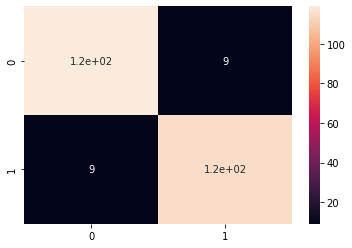

In [47]:
rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)

preds = rfc.predict(X_test)
score = rfc.score(X_test, y_test)
print(score*100)
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True)

### ADJUSTING THRESHOLD WITH PREDICT_PROBA

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       128
           1       0.93      0.91      0.92       124

    accuracy                           0.92       252
   macro avg       0.92      0.92      0.92       252
weighted avg       0.92      0.92      0.92       252



<AxesSubplot:>

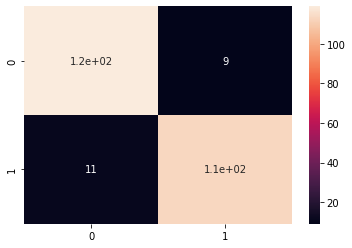

In [48]:
threshold = 0.54
rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)

predicted_proba1 = (rfc.predict_proba(X_test)[:,1] >= threshold).astype("int")

print(classification_report(y_test, predicted_proba1))

cm = confusion_matrix(y_test, predicted_proba1)
sns.heatmap(cm, annot=True)

# VALIDATION DATA LABEL ENCODING

**⚫ Veriseti için diğer bir yöntem olan Label Encoding işlemi validasyon setine uygulandıktan sonra validasyon seti üzerinde modelin başarısı çok kötü durumdadır.Buradaki en büyük problem train_test ve validasyon verisetlerine Label Encoding yapıldığında fonksiyon her bir kolona ait eşsiz değerlere ratgele olarak 0 dan başlayarak artan şekilde nümerik değerler atamaktadır ancak herbir kolondaki eşsiz değere atanan bu nümerik değerler onların hedef değişkene olan etkisini doğru ve gerçek oranda yansıtmamaktadır.**

In [49]:
labelEncoded_valData = valData1.apply(LabelEncoder().transform)

NotFittedError: This LabelEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [50]:
features = []
for col in labelEncoded_valData.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X_val = labelEncoded_valData

from sklearn.preprocessing import StandardScaler

X = sc.transform(X)

NameError: name 'labelEncoded_valData' is not defined

In [51]:
preds1 = rfc.predict(X_val)
score1 = rfc.score(X_val, y_val)
print(score1*100)
print(classification_report(y_val, preds1))

cm = confusion_matrix(y_val, preds1)
sns.heatmap(cm, annot=True)

ValueError: X has 195 features, but RandomForestClassifier is expecting 31 features as input.

#### SOLUTION 1 WHEN LABEL ENCODING FOR VALIDATION DATASET

### 4. Validasyon Dataseti (Modelin Görmediği) nasıl oluşturulur ve nasıl predict etmeye hazır hale getirilir ?
**⚫ Model eğitilip test veriseti üzerinde tahminleme yapıldıktan sonra modelin daha önce hiç görmediği validasyon-gerçek hayat verisi üzerinde de test edilmelidir.Burada  validasyon verisetini oluşturmak ve tahminlemeye hazır hale getirmek için daha önceden label encoded yapılan train_test datasındaki kolonların herbr eşsiz değerlerine karşılık gelen encoded değerlerin validasyon veriseti üzerindeki ilgili kolonun aynı eşsiz değerine implemente edilmesi gerekir.Bu yüzden label encoded edilen train_test verseti üzerinde her bir kolonun herbir eşsiz değeri ve encoded karşılıklarını içeren look-up tablosu oluşturularak bu tablo validasyon verisetine kolon değerleri bazında merge işlemi yapılarak birleştirilir böylece validasyon veriseti üzerindeki kolon değerlerinin yerine train_test verisetinde karşılık gelen  doğru encoded değerleri ile değiştirilmiş olup tahminlemeye hazır hale getirilir.Aşağıdaki kod bloğunda validasyon verisetinin nasıl oluşturulduğu ve tahminlemeye nasıl hazır hale getirildiği gösterilmektedir.**

In [52]:
lab_encoder = LabelEncoder()
labelEncoded_train_testData1 = train_testData1.apply(lab_encoder.fit_transform)

In [53]:
df4 = pd.concat([train_testData1,labelEncoded_train_testData1],axis=1)

In [54]:
df4 = train_testData1
for i in train_testData1.columns:
    df4[i+"_v1"] = labelEncoded_train_testData1[i]

In [55]:
for i in labelEncoded_train_testData1.columns:
    df_change = df4[[i,i+"_v1"]].drop_duplicates()
    valData1 = valData1.merge(df_change,how='left',on=i)

In [56]:
valData1 = valData1.iloc[: , 32:]

In [57]:
valData1.columns = ['policy_state', 'policy_csl', 'umbrella_limit',
       'insured_sex', 'insured_education_level', 'insured_occupation',
       'insured_hobbies', 'insured_relationship',
       'capital_loss_groups', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
        'incident_hour_of_the_day','number_of_vehicles_involved', 'property_damage', 
        'bodily_injuries','witnesses', 'police_report_available', 'total_claim_amount_groups',
       'auto_make', 'auto_model', 'auto_year',
       'claim_day_of_policy_groups', 'location_check', 'age_group',
       'months_as_customer_groups', 'policy_annual_premium_groups',
       'policy_deductable_group' , 'fraud_reported']

ValueError: Length mismatch: Expected axis has 30 elements, new values have 32 elements

In [58]:
X_val = valData1.iloc[ : , : 31]
y_val = valData1.iloc[: ,  -1]

preds = rfc.predict(X_val)

score = rfc.score(X_val, y_val)
print(score*100)
print()
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

D:\Program Files\Python\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 30 features, but RandomForestClassifier is expecting 31 features as input.

**⚫ Buradaki kod bloğunda hata alınmasının sebebi train_test ve validasyon verisetleri arasında uniform dağılım olmadığından bazı labellar validasyon verisetinde bulunmamaktadır ve scikit-learn kütüphanesinde bulunan LabelEncoder metodu ile validasyon verisetine yukarıda One-Hot Encoding de uygulanan transform yapılamamıştır.**

In [59]:
# Apply the encoder.
labelEncoded_valData1 = valData1.apply(lab_encoder.transform)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

#### SOLUTION 2 WHEN LABEL ENCODING FOR VALIDATION DATASET

### 2. LabelEncoding de ilgili kolon için ölçeklendirme nasıl yapılır ? (Verinin doğru etkisi ile sayısal olarak dönüştürülmesi)
**⚫ Bu son kısımda ise train_test verisetinde herbir kolon içinde bulunan eşsiz değerlerin hedef değişkene olan etkisi sayısal  değerlere dönüştürülerek doğru bir ölçekleme yapılıp ardından validasyon seti de doğru sayısal ölçekleme ile label encoded edilen train_test veriseti yardımı ile hazırlanıp tahminlemeye hazır hale getirilmiş ve model perfomansı olarak train_test , validasyon süreçlerinde başarılı sonuç alınmıştır.Son olarak da başarılı model üzerinde hyperparameter tuning  ve threshold adjustment yapılarak model iyileştirilemeye çalışılmıştır.Aşağıdaki kısımlarda labelEncoded_train_testData2 ve valData adlı iki veriseti üzerinde train_test ve validasyon setlerinin doğru sayısal ölçekleme ile label encoded halleri görülmektedir.Burada doğru sayısal ölçeklemenin nasıl yapıldığından bahsedecek olursak devreye veri analizi girmektedir. Train_test Veri seti hedef değişken bakımından  1 ve 0 lara ayrılıp daha sonra herbir kolona ait eşsiz değerlerin 1 lerdeki sayıları 0 lara oranlanarak o kolona ait eşsiz değerlerdeki 1 lerin 0 lara olan etkisi sayısal olarak ölçeklendirilmiştir ayrıca modeli iyileştirmek adına  ileriye dönük çalışmalar için en başta kolon bazında farklı ve daha hassas gruplamalar yapılarak daha net ve doğru bir label encoding ölçeklendirmesi yapılabilir.**

In [60]:
train_testData

,policy_state,policy_csl,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital_loss_groups,incident_type,...,auto_make,auto_model,auto_year,claim_day_of_policy_groups,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group,fraud_reported
511,OH,MISSING,0.0,FEMALE,JD,sales,other,husband,-50000 - -40000,Parked Car,...,Volkswagen,Jetta,2003,4000-5000,False,46-50,251-300,medium,501-1000,0
894,IN,MISSING,0.0,MALE,MD,priv-house-serv,other,not-in-family,-10000 - 0,Parked Car,...,Suburu,Impreza,2000,8000-9000,False,31-35,0-50,medium,0-500,0
125,IN,MISSING,other,MALE,JD,craft-repair,other,unmarried,-70000 - -60000,Multi-vehicle Collision,...,Ford,Escape,2013,0-1000,False,36-40,201-250,medium,501-1000,0
895,IL,MISSING,0.0,MALE,High School,armed-forces,other,own-child,-10000 - 0,Multi-vehicle Collision,...,Saab,92x,1998,1000-2000,False,36-40,151-200,medium,0-500,1
485,IN,MISSING,0.0,MALE,Associate,adm-clerical,other,husband,-40000 - -30000,Single Vehicle Collision,...,Nissan,Maxima,1995,7000-8000,False,26-30,51-100,medium,1501-2000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,IN,MISSING,0.0,FEMALE,JD,machine-op-inspct,other,other-relative,-10000 - 0,Multi-vehicle Collision,...,Ford,F150,2011,8000-9000,False,26-30,101-150,high,0-500,0
457,IL,100/300,0.0,MALE,Masters,transport-moving,other,own-child,-50000 - -40000,Single Vehicle Collision,...,Volkswagen,Passat,2011,0-1000,False,26-30,101-150,high,1501-2000,1
478,IL,500/1000,9999,MALE,Masters,armed-forces,chess,unmarried,-10000 - 0,Vehicle Theft,...,Mercedes,C300,2001,6000-7000,False,51-55,401-450,low,1501-2000,1
41,IN,250/500,0.0,MALE,Associate,transport-moving,chess,unmarried,-30000 - -20000,Single Vehicle Collision,...,BMW,X5,2001,0-1000,False,9999,101-150,high,0-500,1


In [61]:
train_testData_copy2 = train_testData.iloc[: , : 32]

In [62]:
train_testData_1 = train_testData_copy2[train_testData_copy2["fraud_reported"] == 1]
train_testData_0 = train_testData_copy2[train_testData_copy2["fraud_reported"] == 0]

In [63]:
train_testData_1 = train_testData_1.drop("fraud_reported" , 1)
train_testData_0 = train_testData_0.drop("fraud_reported" , 1)

C:\Users\Ugur\AppData\Local\Temp/ipykernel_1552/3038505372.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train_testData_1 = train_testData_1.drop("fraud_reported" , 1)
C:\Users\Ugur\AppData\Local\Temp/ipykernel_1552/3038505372.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train_testData_0 = train_testData_0.drop("fraud_reported" , 1)


**⚫ Aşağıdaki kod bloğunda train_test veriseti için sayısal olarak label encoding ölçeklendirme yapılmaktadır.**

In [64]:
for col in train_testData_1.columns :
    val1 = train_testData_1[col].value_counts().to_frame()
    val1 = val1.rename(columns= {col: col + "_1"})

    val0 = train_testData_0[col].value_counts().to_frame()
    val0 = val0.rename(columns= {col: col + "_0"})

    val1 = val1.merge(val0, left_index=True, right_index=True)
    
    val1["1_0_ratio"] = val1[col + "_1"] / val1[col + "_0"]

    for index in val1.index :
        train_testData_copy2[col].replace({index : val1.loc[index,"1_0_ratio"]}, inplace=True)


In [65]:
labelEncoded_train_testData2 = train_testData_copy2

In [66]:
labelEncoded_train_testData2["auto_model"].replace({"3 Series": 0.0}, inplace=True)
labelEncoded_train_testData2["policy_annual_premium_groups"].replace({"very high": 1.0}, inplace=True)

In [67]:
total = labelEncoded_train_testData2.isnull().sum().sort_values(ascending=False)
percent = (labelEncoded_train_testData2.isnull().sum()/labelEncoded_train_testData2.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
claim_day_of_policy_groups,1,0.00125
capital_loss_groups,1,0.00125
policy_state,0,0.00000
property_damage,0,0.00000
policy_deductable_group,0,0.00000
policy_annual_premium_groups,0,0.00000
months_as_customer_groups,0,0.00000
age_group,0,0.00000
location_check,0,0.00000
auto_year,0,0.00000


In [68]:
labelEncoded_train_testData2 = labelEncoded_train_testData2.fillna(0.0)

In [69]:
for col in labelEncoded_train_testData2.columns :
    print(labelEncoded_train_testData2[col].value_counts())

0.291667    279
0.397959    274
0.387640    247
Name: policy_state, dtype: int64
0.330134    693
0.500000     39
1.000000     36
0.280000     32
Name: policy_csl, dtype: int64
0.336842    508
0.369748    163
0.417582    129
Name: umbrella_limit, dtype: int64
0.329193    428
0.388060    372
Name: insured_sex, dtype: int64
0.350000    135
0.306931    132
0.367816    119
0.337209    115
0.313253    109
0.436620    102
0.419355     88
Name: insured_education_level, dtype: int64
0.333333    72
0.296296    70
0.425532    67
0.382979    65
0.585366    65
0.377778    62
0.229167    59
0.513514    56
0.384615    54
0.232558    53
0.361111    49
0.184211    45
0.419355    44
0.300000    39
Name: insured_occupation, dtype: int64
0.271626    735
6.200000     36
3.142857     29
Name: insured_hobbies, dtype: int64
0.278261    147
0.371429    144
0.447917    139
0.288660    125
0.409091    124
0.359551    121
Name: insured_relationship, dtype: int64
0.361011    377
0.341772    106
0.400000     91
0.3

In [70]:
X2 = labelEncoded_train_testData2.iloc[ : , : 30]
y2 = labelEncoded_train_testData2.iloc[: ,  -1]

In [71]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X2 = sc.fit_transform(X2)

In [72]:
oversample = SMOTE(random_state=9)
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.3,  random_state = 42)
X_over, y_over = oversample.fit_resample(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, random_state = 1)

95.63492063492063
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       128
           1       0.94      0.97      0.96       124

    accuracy                           0.96       252
   macro avg       0.96      0.96      0.96       252
weighted avg       0.96      0.96      0.96       252



<AxesSubplot:>

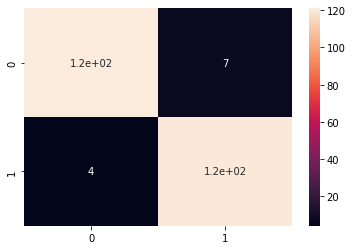

In [73]:
rfc1 = RandomForestClassifier(random_state = 1)
rfc1.fit(X_train, y_train)

preds = rfc1.predict(X_test)
score = rfc1.score(X_test, y_test)
print(score*100)
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True)

**⚫ Sayısal olarak doğru ölçeklendirilmiş train_test veriseti**

In [74]:
labelEncoded_train_testData2

,policy_state,policy_csl,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital_loss_groups,incident_type,...,auto_make,auto_model,auto_year,claim_day_of_policy_groups,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group,fraud_reported
511,0.397959,0.330134,0.336842,0.329193,0.350000,0.382979,0.271626,0.288660,0.341772,0.087719,...,0.390244,0.333333,0.241379,0.367647,0.34753,0.210526,0.270270,0.330900,0.316038,0
894,0.387640,0.330134,0.336842,0.388060,0.367816,0.229167,0.271626,0.371429,0.361011,0.087719,...,0.326923,0.357143,0.454545,0.344828,0.34753,0.372549,0.469388,0.330900,0.370558,0
125,0.387640,0.330134,0.417582,0.388060,0.350000,0.377778,0.271626,0.359551,0.264151,0.399160,...,0.400000,0.400000,0.444444,0.375000,0.34753,0.257143,0.348837,0.330900,0.316038,0
895,0.291667,0.330134,0.336842,0.388060,0.306931,0.384615,0.271626,0.278261,0.361011,0.399160,...,0.285714,0.411765,0.192308,0.327273,0.34753,0.257143,0.413333,0.330900,0.370558,1
485,0.387640,0.330134,0.336842,0.388060,0.337209,0.184211,0.271626,0.288660,0.380000,0.447368,...,0.269231,0.538462,0.314286,0.438596,0.34753,0.325301,0.362069,0.330900,0.386740,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,0.387640,0.330134,0.336842,0.329193,0.350000,0.333333,0.271626,0.447917,0.361011,0.399160,...,0.400000,0.454545,0.500000,0.344828,0.34753,0.325301,0.301075,0.372340,0.370558,0
457,0.291667,0.500000,0.336842,0.388060,0.313253,0.513514,0.271626,0.278261,0.341772,0.447368,...,0.390244,0.450000,0.500000,0.375000,0.34753,0.325301,0.301075,0.372340,0.386740,1
478,0.291667,0.280000,0.369748,0.388060,0.313253,0.384615,6.200000,0.359551,0.361011,0.119403,...,0.678571,0.625000,0.360000,0.343284,0.34753,0.400000,0.285714,0.457831,0.386740,1
41,0.387640,1.000000,0.336842,0.388060,0.337209,0.513514,6.200000,0.359551,0.388889,0.447368,...,0.432432,0.555556,0.360000,0.375000,0.34753,0.480000,0.301075,0.372340,0.370558,1


In [75]:
train_testData3 = train_testData.iloc[: , : 32]

**⚫ Aşağıdaki kod blokları validasyon verisetinin hazırlanmasını ve tahminlemeye hazır hale getirilme aşamalarını içermektedir.**

In [76]:
df5 = pd.concat([train_testData3,labelEncoded_train_testData2],axis=1)

In [77]:
df5 = train_testData3
for i in train_testData3.columns:
    df5[i+"_v1"] = labelEncoded_train_testData2[i]

In [78]:
valData = df.sort_values(by='incident_date',ascending=False).head(200)
valData = valData.drop(["incident_date","insured_zip","incident_location"],axis=1)
valData

,policy_state,policy_csl,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital_loss_groups,incident_type,...,auto_make,auto_model,auto_year,claim_day_of_policy_groups,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group,fraud_reported
752,IL,MISSING,0.0,MALE,PhD,machine-op-inspct,other,unmarried,-10000 - 0,Multi-vehicle Collision,...,Chevrolet,Tahoe,1997,5000-6000,False,9999,401-450,low,0-500,0
74,IL,MISSING,0.0,FEMALE,Associate,sales,other,wife,-10000 - 0,Multi-vehicle Collision,...,BMW,X6,2005,3000-4000,False,36-40,201-250,medium,501-1000,0
914,OH,MISSING,0.0,FEMALE,JD,transport-moving,cross-fit,own-child,-70000 - -60000,Multi-vehicle Collision,...,Honda,Accord,1998,5000-6000,False,36-40,101-150,low,1501-2000,0
883,OH,MISSING,0.0,FEMALE,Associate,exec-managerial,other,not-in-family,-10000 - 0,Multi-vehicle Collision,...,Audi,A5,2005,3000-4000,False,31-35,101-150,medium,501-1000,1
839,OH,MISSING,0.0,MALE,Associate,protective-serv,other,own-child,-50000 - -40000,Single Vehicle Collision,...,Dodge,Neon,2011,9000-10000,False,41-45,201-250,medium,0-500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,IN,MISSING,0.0,FEMALE,College,prof-specialty,other,other-relative,-40000 - -30000,Single Vehicle Collision,...,BMW,X5,2015,5000-6000,False,9999,201-250,medium,1501-2000,0
937,IN,MISSING,0.0,FEMALE,High School,protective-serv,other,wife,-10000 - 0,Single Vehicle Collision,...,Jeep,Grand Cherokee,1995,2000-3000,False,56-60,451-500,high,501-1000,0
77,IN,MISSING,9999,MALE,College,transport-moving,other,not-in-family,-10000 - 0,Multi-vehicle Collision,...,Audi,A3,2005,8000-9000,False,46-50,301-350,medium,0-500,0
835,IN,MISSING,other,MALE,JD,other-service,other,wife,-60000 - -50000,Vehicle Theft,...,Mercedes,ML350,2015,0-1000,False,51-55,351-400,medium,1501-2000,0


In [79]:
for i in labelEncoded_train_testData2.columns:
    df_change = df5[[i,i+"_v1"]].drop_duplicates()
    valData = valData.merge(df_change,how='left',on=i)

In [80]:
valData = valData.iloc[: , 32:]

In [81]:
valData.columns = ['policy_state', 'policy_csl', 'umbrella_limit',
       'insured_sex', 'insured_education_level', 'insured_occupation',
       'insured_hobbies', 'insured_relationship', 
       'capital_loss_groups', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
        'incident_hour_of_the_day','number_of_vehicles_involved', 'property_damage', 
        'bodily_injuries','witnesses', 'police_report_available', 'total_claim_amount_groups',
       'auto_make', 'auto_model', 'auto_year',
       'claim_day_of_policy_groups', 'location_check', 'age_group',
       'months_as_customer_groups', 'policy_annual_premium_groups',
       'policy_deductable_group' , 'fraud_reported']

**⚫ Sayısal olarak doğru ölçeklendirilmiş validasyon veriseti**

In [82]:
valData

,policy_state,policy_csl,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital_loss_groups,incident_type,...,auto_make,auto_model,auto_year,claim_day_of_policy_groups,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group,fraud_reported
0,0.291667,0.330134,0.336842,0.388060,0.436620,0.333333,0.271626,0.359551,0.361011,0.399160,...,0.465116,0.818182,0.444444,0.392857,0.34753,0.480000,0.285714,0.457831,0.370558,0
1,0.291667,0.330134,0.336842,0.329193,0.337209,0.382979,0.271626,0.409091,0.361011,0.399160,...,0.432432,1.000000,0.290323,0.278689,0.34753,0.257143,0.348837,0.330900,0.316038,0
2,0.397959,0.330134,0.336842,0.329193,0.350000,0.513514,3.142857,0.278261,0.264151,0.399160,...,0.333333,0.285714,0.192308,0.392857,0.34753,0.257143,0.301075,0.457831,0.386740,0
3,0.397959,0.330134,0.336842,0.329193,0.337209,0.585366,0.271626,0.371429,0.361011,0.399160,...,0.447368,0.529412,0.290323,0.278689,0.34753,0.372549,0.301075,0.330900,0.316038,1
4,0.397959,0.330134,0.336842,0.388060,0.337209,0.361111,0.271626,0.278261,0.341772,0.447368,...,0.367347,0.153846,0.500000,0.555556,0.34753,0.340206,0.348837,0.330900,0.370558,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.387640,0.330134,0.336842,0.329193,0.419355,0.296296,0.271626,0.447917,0.380000,0.447368,...,0.432432,0.555556,0.285714,0.392857,0.34753,0.480000,0.348837,0.330900,0.386740,0
196,0.387640,0.330134,0.336842,0.329193,0.306931,0.361111,0.271626,0.409091,0.361011,0.447368,...,0.232558,0.357143,0.314286,0.323077,0.34753,0.619048,0.608696,0.372340,0.316038,0
197,0.387640,0.330134,0.369748,0.388060,0.419355,0.513514,0.271626,0.371429,0.361011,0.399160,...,0.447368,0.380952,0.290323,0.344828,0.34753,0.210526,0.234043,0.330900,0.370558,0
198,0.387640,0.330134,0.417582,0.388060,0.350000,0.232558,0.271626,0.409091,0.400000,0.119403,...,0.678571,1.166667,0.285714,0.375000,0.34753,0.400000,0.700000,0.330900,0.386740,0


76.0

              precision    recall  f1-score   support

           0       0.95      0.75      0.84       163
           1       0.42      0.81      0.56        37

    accuracy                           0.76       200
   macro avg       0.68      0.78      0.70       200
weighted avg       0.85      0.76      0.78       200



<AxesSubplot:>

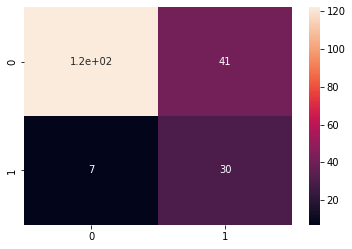

In [83]:
X_val2 = valData.iloc[ : , : 30]
y_val2 = valData.iloc[: ,  -1]

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_val2 = sc.fit_transform(X_val2)

preds2 = rfc1.predict(X_val2)

score = rfc1.score(X_val2, y_val2)
print(score*100)
print()
print(classification_report(y_val2, preds2))

cm = confusion_matrix(y_val2, preds2)
sns
sns.heatmap(cm, annot=True)

 ### VALIDATION DATA LABEL ENCODING WITH REAL VALUES SCALED - HYPERPARAMETER TUNING 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 1000, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf3 = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf3, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42 , n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

94.84126984126983
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       128
           1       0.93      0.97      0.95       124

    accuracy                           0.95       252
   macro avg       0.95      0.95      0.95       252
weighted avg       0.95      0.95      0.95       252



<AxesSubplot:>

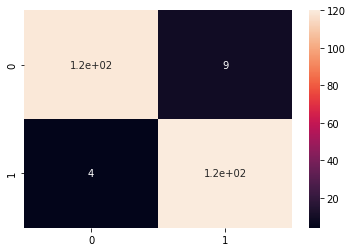

In [84]:
rf3 = RandomForestClassifier(random_state=42, n_estimators=650,min_samples_split=2,min_samples_leaf=2,max_features='sqrt'
                            ,max_depth=30,bootstrap='False')
rf3.fit(X_train, y_train)

preds = rf3.predict(X_test)

score = rf3.score(X_test, y_test)
print(score*100)

print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True)

77.0

              precision    recall  f1-score   support

           0       0.94      0.77      0.84       163
           1       0.43      0.78      0.56        37

    accuracy                           0.77       200
   macro avg       0.69      0.78      0.70       200
weighted avg       0.85      0.77      0.79       200



<AxesSubplot:>

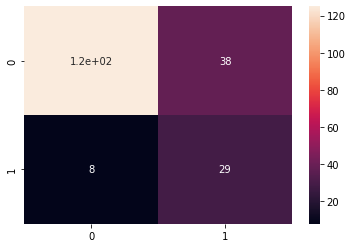

In [85]:
X_val2 = valData.iloc[ : , : 30]
y_val2 = valData.iloc[: ,  -1]

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_val2 = sc.fit_transform(X_val2)

preds2 = rf3.predict(X_val2)

score = rf3.score(X_val2, y_val2)
print(score*100)
print()
print(classification_report(y_val2, preds2))

cm = confusion_matrix(y_val2, preds2)
sns
sns.heatmap(cm, annot=True)

### ADJUSTING THRESHOLD WITH PREDICT PROBA

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       128
           1       0.94      0.97      0.96       124

    accuracy                           0.96       252
   macro avg       0.96      0.96      0.96       252
weighted avg       0.96      0.96      0.96       252



<AxesSubplot:>

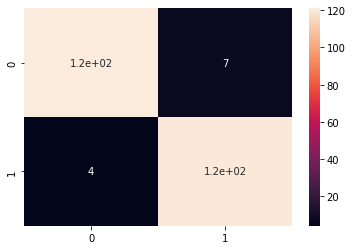

In [86]:
threshold = 0.52

rfc1 = RandomForestClassifier(random_state = 1)
rfc1.fit(X_train, y_train)

predicted_proba2 = (rfc1.predict_proba(X_test)[:,1] >= threshold).astype("int")

print(classification_report(y_test, predicted_proba2))

cm = confusion_matrix(y_test, predicted_proba2)
sns.heatmap(cm, annot=True)

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       163
           1       0.46      0.81      0.59        37

    accuracy                           0.79       200
   macro avg       0.70      0.80      0.72       200
weighted avg       0.86      0.79      0.81       200



<AxesSubplot:>

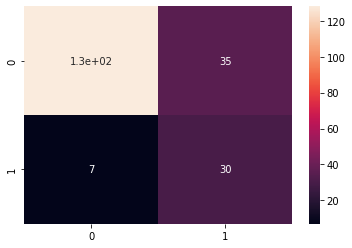

In [87]:
threshold = 0.54

predicted_proba2 = (rfc1.predict_proba(X_val2)[:,1] >= threshold).astype("int")

print(classification_report(y_val2, predicted_proba2))

cm = confusion_matrix(y_val2, predicted_proba2)
sns.heatmap(cm, annot=True)

#### 

### CONCLUSION
**Burada verisetimiz hem One-Hot Encoding (%87 - %45) hem de sayısal olarak doğru ölçekledirme ile Label Encoding(%86 - %59) uygulanarak iki farklı model ile train_test validasyon split süreçlerinin ardından performans olarak başarılı sonuçlar almıştır.**